# Model Inference for New Data

After training a model on historical data, most common next step is inferering the outcome for the new data. MultiViz Analytics Engine (MVG) supports this by providing a feature called `ApplyModel`. To invoke this feature a successful analysis is required. Then, the `request_id` of that anaysis is used to refer to the model and apply it on any range of data on the same source or any source that has the same columns (or channels). 

This example using data from the Iris dataset illustrates how this process can be achieved.

### Setup the connection

In [1]:
import os
from mvg import MVG, plotting
from sklearn.datasets import load_iris
import pandas as pd

In [2]:
ENDPOINT = "http://api.beta.multiviz.com"
# Replace by your own Token
TOKEN = os.environ["TEST_TOKEN"]

In [3]:
session = MVG(ENDPOINT, TOKEN)

### Load the data
The data from Iris dataset needs to be wrangled to conform to the format used by MVG.
The data is in the form of a 2D numpy array which needs to be converted to a dictionary where each key holds the name of a column (in this case features of the plants) and the corresponding values.

In [4]:
dataset = load_iris()
column_names = dataset["feature_names"]
column_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
data = {}
for idx, name in enumerate(column_names):
    data[name] = list((dataset["data"][:,idx]))

Note that this dataset is not a timeseries dataset.
It is chosen because of its availability in the common python packages like sklearn.
However, it is sufficient for demonstration purposes of the `ApplyModel` feature.
MVG requires timestamps for each datapoint to be provided as well.
We use dummy timestamps from 0 to 149.

In [6]:
data["timestamp"] = list(range(len(dataset["data"])))

### Create source and measurements
A tabular source with these measurements needs to be created for the model to be built.

In [7]:
session.create_tabular_source(sid="iris", columns=column_names, meta={}, exist_ok=True)
session.create_tabular_measurement(sid="iris", data=data, meta={}, exist_ok=True)

The three classes in the data are indicated in `dataset["target"]`.
Data is divided into three equal parts, each with 50 samples for each class.

In [8]:
dataset["target"]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Build the model

To demonstrate `ApplyModel` as a feature, we train a model on the middle 100 samples and then apply the trained model on the entire data.

In [9]:
request_data = session.request_analysis(
    sid="iris", 
    feature="ModeId",
    start_timestamp=25, 
    end_timestamp=124)
request_id = request_data["request_id"]

Helper function `wait_for_analysis` allows the possibility of waiting for the termination a group of analyses jobs.

In [10]:
session.wait_for_analyses(request_id_list=[request_id])

In [11]:
mode_output = session.get_analysis_results(request_id=request_id)

### Review the results

We can plot the result of the analysis that shows the three distinct modes.

[]

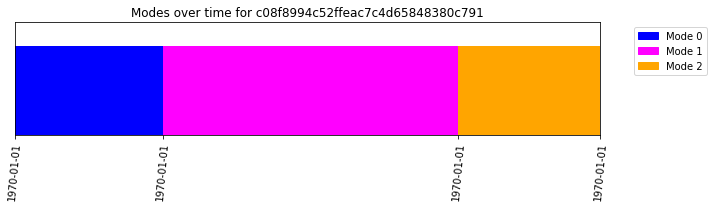

In [12]:
mode_output["results"].pop("mode_info", None)
mode_output["results"].pop("mode_probabilities", None)
plotting.modes_over_time(pd.DataFrame(mode_output["results"]), request_id)


Comparing the resulting labels with the ground-truth in the original iris dataset shows that the borders are identified precisely.
Note that `ModeId` feature sorts the ID of modes in a way that the ID for the first encountered mode is reported as 0, the second mode as 1, and so on.
This happens to be the case in the iris dataset as well but for other datasets sorting of modes needs to be done before comparison.

In [13]:
all(mode_output["results"]["labels"] == dataset["target"][25:125])

True

## Apply the model on the whole dataset

Now, we apply the model on the entire dataset.
To that end, we need to call `ApplyModel` feature and provide the `request_id` of the analysis that contains the model.
Note that running `ApplyModel` is much faster than `ModeId`.

In [14]:
request_data_am = session.request_analysis(
    sid="iris", 
    feature="ApplyModel",
    parameters={"model_ref": request_id}
)
request_id_am = request_data_am["request_id"]
session.wait_for_analyses(request_id_list=[request_id_am])

In [15]:
am_output = session.get_analysis_results(request_id=request_id_am)

### Review the results of the inference

Comparing the results, show that the first 25 and last 25 elements of the data that was excluded while building the model in earlier steps are now correctly classified.

In [16]:
all(am_output["results"]["labels"]==dataset["target"])


True